# Feature extraction for the merged data

In [1]:
# imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from feature_engine.transformation import LogTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor


In [2]:
merged_df =  pd.read_csv(".\data\merged_PAS_Crine.csv")

In [3]:
merged_df.columns

Index(['Date', 'Anti-social behaviour', 'Other crime', 'Burglary',
       'Vehicle crime', 'Robbery', 'Other theft', 'Criminal damage and arson',
       'Drugs', 'Shoplifting', 'Violence and sexual offences',
       'Theft from the person', 'Public order', 'Bicycle theft',
       'Possession of weapons', 'Proportion'],
      dtype='object')

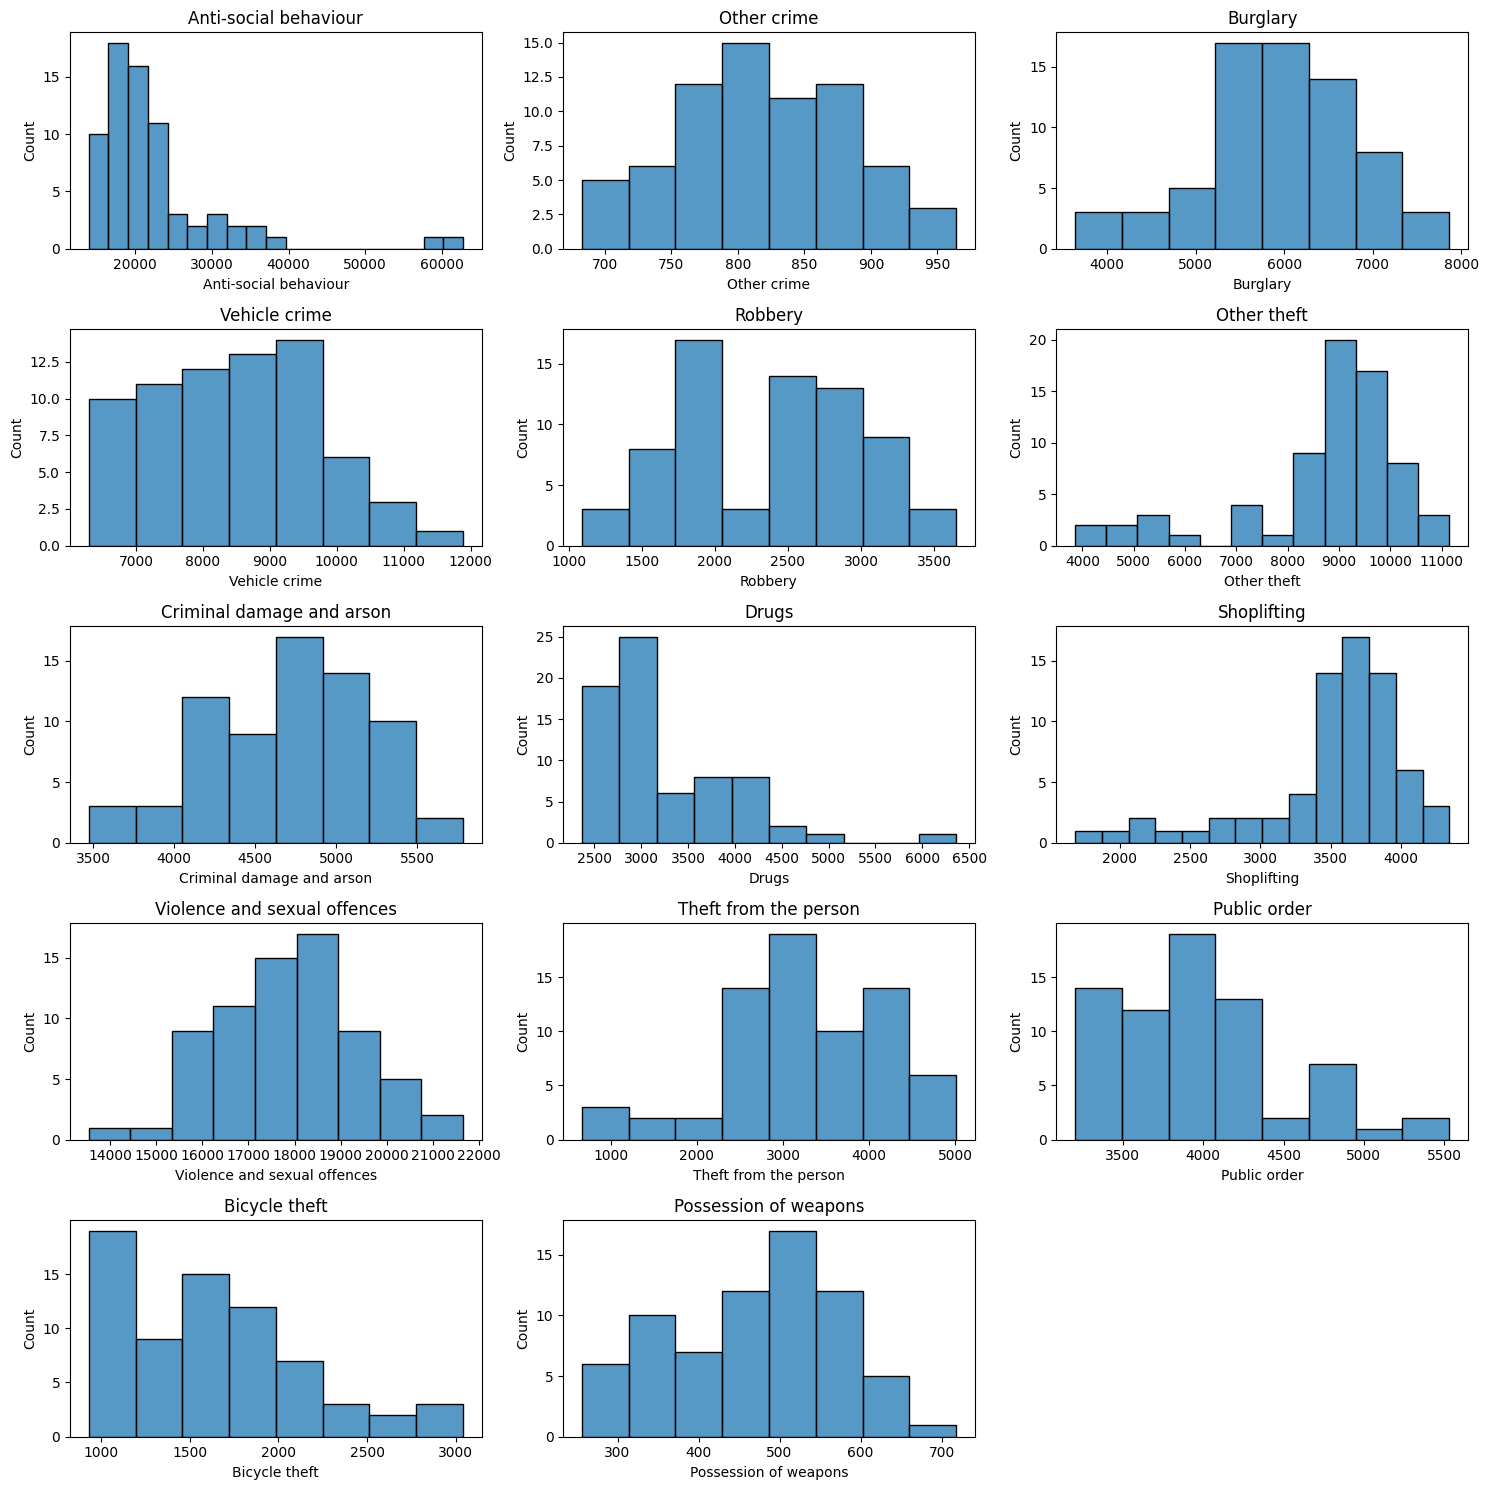

In [4]:
columns_to_plot = merged_df.columns[1:len(merged_df.columns)-1]

fig, axs = plt.subplots(5, 3, figsize=(15, 15))

# Flatten the 2D array of axes to easily iterate over them
axs = axs.flatten()

# Iterate over the columns and plot
for i, col in enumerate(columns_to_plot):
    sns.histplot(data=merged_df, x=col, ax=axs[i])
    axs[i].set_title(col)

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

    

In [5]:
def AllCrimes(row, columns):
    total = 0 
    for element in columns:
        total += row[element]
    return total

In [6]:

features = list(columns_to_plot)

merged_df["All crimes"] = merged_df.apply(lambda row: AllCrimes(row, features), axis=1)

features.append("All crimes")

log_transformation = Pipeline([
    ('log', LogTransformer(variables=features))
])

# Define the square root function
def sqrt_transform(X):
    return np.sqrt(X)

def LogarithmProportion(row, column_name):
    p = row[column_name]
    return np.log(p/(1-p))

sqr_transformation = Pipeline([
    ('sqrt_transform', FunctionTransformer(func=sqrt_transform, validate=False))

])

minmax_transformation = Pipeline([
    ('minmax', MinMaxScaler())
])


merged_df["Proportion"] = merged_df.apply(lambda row: LogarithmProportion(row, "Proportion"), axis=1)


logged_data = log_transformation.fit_transform(merged_df)
logged_data = logged_data.drop(["Proportion", "Date"], axis=1)
sqr_data = sqr_transformation.fit_transform(merged_df[features])
minmax_data = minmax_transformation.fit_transform(merged_df[features])
minmax_data = pd.DataFrame(minmax_data, columns=features)

In [7]:
# stores new names for dataframes
log_dict = {}
sqr_dict = {}
minmax_dict = {}

for col in logged_data.columns:

    col_log = "log_" + col 
    col_sqr = "sqr_" + col 
    col_minmax = "minmax_" + col 

    log_dict[col] = col_log
    sqr_dict[col] = col_sqr
    minmax_dict[col] = col_minmax


# Rename columns
logged_data.rename(columns=log_dict, inplace=True)
sqr_data.rename(columns=sqr_dict, inplace=True)
minmax_data.rename(columns=minmax_dict, inplace=True)


# Feature selction of transformed data

In [8]:
concatenated_df = pd.concat([merged_df, logged_data, sqr_data, minmax_data], axis=1)

In [9]:
X = concatenated_df.drop(columns=['Proportion', 'Date'])  # Drop 'Date' and the target variable
y = concatenated_df['Proportion']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=250, max_depth=5, random_state=1)
reg.fit(X_train, y_train)

importance = reg.feature_importances_

indices = np.argsort(importance)[::-1]

(-1.0, 60.0)

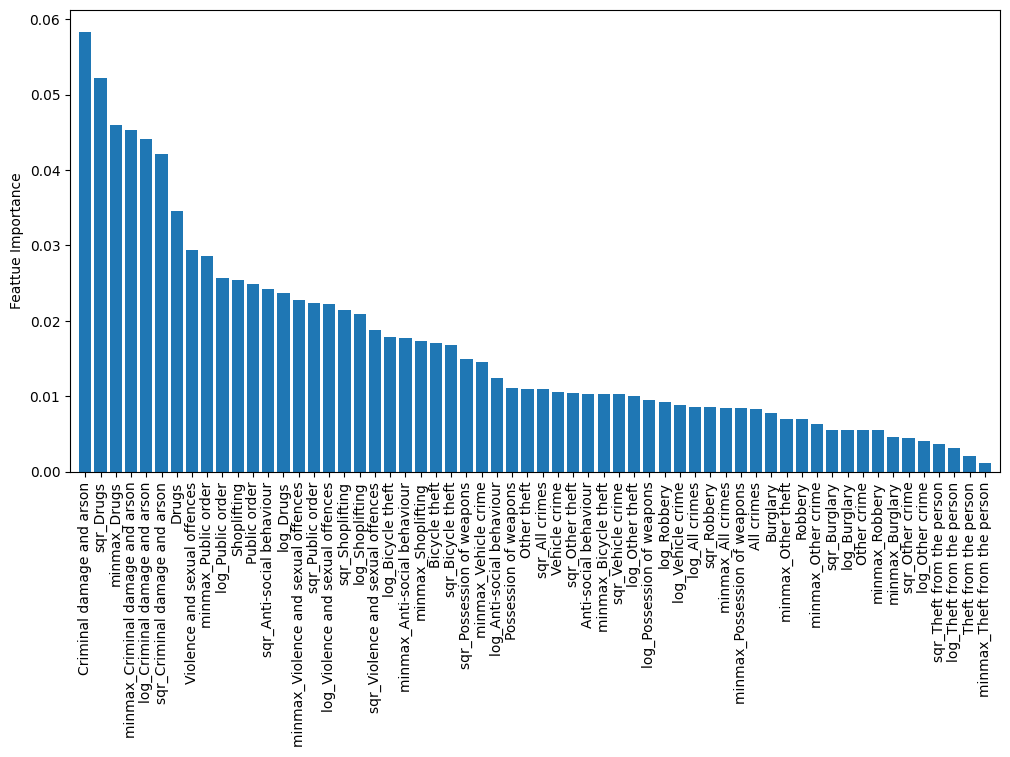

In [10]:


feat_labels = X.columns

plt.figure(figsize=(12, 6))
plt.ylabel("Feattue Importance")
plt.bar(range(X_train.shape[1]),
        importance[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

### tactic for feature selection: 
Select max 7 features and then differnt number of features will be tested using cross validation
We do not consider repetitions of transformed feature
Selected features:
1. Criminal damage and arson
2. sqr_Drugs
3. Violannce and sexual offence
4. minmax_Public order
5. Shoplifting
6. sqr_Anti social behaviour
7. log_Bicycle theft

In [17]:
# creating a file
transformed_features = ['Date', 'Criminal damage and arson','sqr_Drugs', 'Violence and sexual offences', 
'minmax_Public order', 'Shoplifting', 'sqr_Anti-social behaviour', 'log_Bicycle theft', 'Proportion']

concatenated_df['Date'] = pd.to_datetime(concatenated_df['Date'])


concatenated_df[transformed_features].to_csv(r".\data\transformed_data.csv")
concatenated_df.to_csv(r".\data\all_transform_data.csv")

# Feature selection of not transformed data

(-1.0, 15.0)

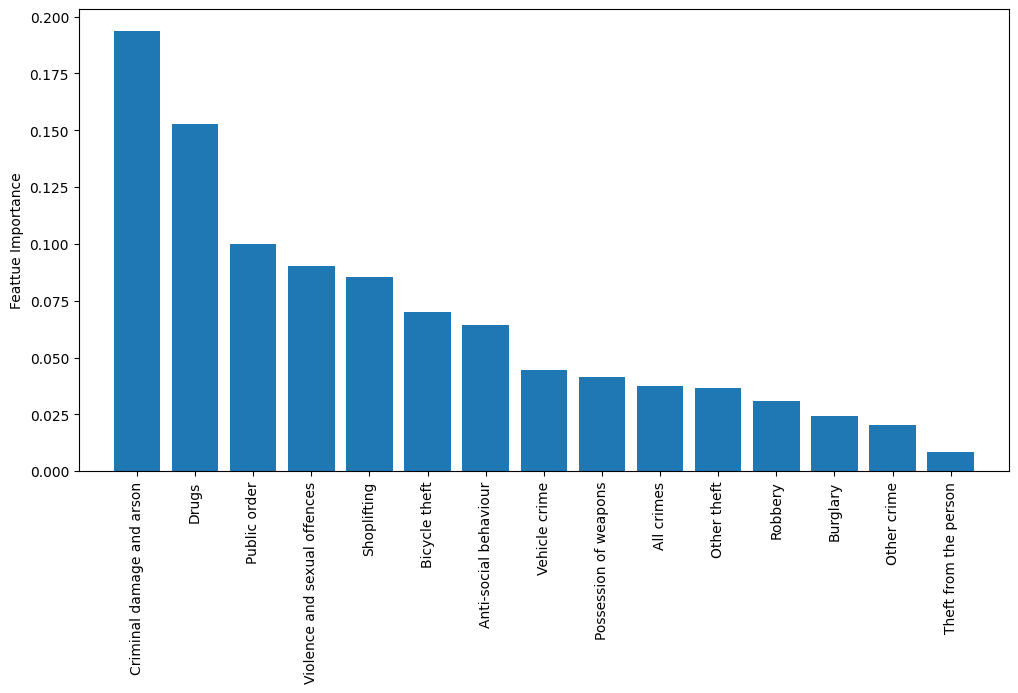

In [12]:
X_casual = merged_df.drop(columns=['Proportion', 'Date'])  # Drop 'Date' and the target variable
y_casual = merged_df['Proportion']


X_train_casual, X_test_casual, y_train_casual, y_test_casual = train_test_split(X_casual, y_casual, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=250, max_depth=5, random_state=1)
reg.fit(X_train_casual, y_train_casual)

importance_casual = reg.feature_importances_

indices_casual = np.argsort(importance_casual)[::-1]

feat_labels_casual = X_train_casual.columns

plt.figure(figsize=(12, 6))
plt.ylabel("Feattue Importance")
plt.bar(range(X_train_casual.shape[1]),
        importance_casual[indices_casual],
        align='center')

plt.xticks(range(X_train_casual.shape[1]),
           feat_labels_casual[indices_casual], rotation=90)

plt.xlim([-1, X_train_casual.shape[1]])

# Casual features based on random forest:

1. Criminal damage and arson
2. Drugs
3. Public order
4. Violance and sexual offences
5. Shoplifting
6. Bicycle theft
7. Anti-social behaviour

In [16]:
# creating a file
casual_features = ['Date', 'Criminal damage and arson', 'Drugs', 'Public order', 'Violence and sexual offences' , 'Shoplifting', 'Bicycle theft', 'Anti-social behaviour', 'Proportion']

merged_df['Date'] = pd.to_datetime(merged_df['Date'])


merged_df[casual_features].to_csv(".\data\simple_data.csv")

pandas._libs.tslibs.timestamps.Timestamp